In [1]:
#This performs experiments with the Moran model.
#Code written by Mark Jayson Cortez for MATH6397.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

In [2]:
def generate_transition_matrix(N,mu_a,mu_A):
    T=np.zeros([N+1,N+1])
    for i in range(N+1):
        if i<N:
            T[i,i+1]=((i/N)*(1-mu_a)+((N-i)/N)*mu_A)*((N-i)/N)
        if i>0:
            T[i,i-1]=(((N-i)/N)*(1-mu_A)+(i/N)*mu_a)*(i/N)
        T[i,i]=1-((i/N)*(1-mu_a)+((N-i)/N)*mu_A)*((N-i)/N)-(((N-i)/N)*(1-mu_A)+(i/N)*mu_a)*(i/N)
    return T

def generate_transition_matrix_selection(N,mu_a,mu_A,r):  #constant fitness
    T=np.zeros([N+1,N+1])
    for i in range(N+1):
        frac1=(r*i)/(r*i+N-i)
        frac2=(N-i)/(r*i+N-i)
        if i<N:
            T[i,i+1]=(frac1*(1-mu_a)+(1-frac1)*mu_A)*((N-i)/N)
        if i>0:
            T[i,i-1]=(frac2*(1-mu_A)+(1-frac2)*mu_a)*(i/N)
        T[i,i]=1-(frac1*(1-mu_a)+(1-frac1)*mu_A)*((N-i)/N)-(frac2*(1-mu_A)+(1-frac2)*mu_a)*(i/N)
    return T

def generate_last_state(N,L,pi_0,mu_a,mu_A,typ,r):
    S=np.eye(N+1,N+1)
    if typ=='selection':
        T=generate_transition_matrix_selection(N,mu_a,mu_A,r)
    else:
        T=generate_transition_matrix(N,mu_a,mu_A) 
    for t in range(1,L):
        S=np.dot(T,S)
    return np.dot(pi_0,S)

def generate_trajectory(N,mu_a,mu_A,typ,r):
    M=10000
    v=[-1,0,1]
    x=np.eye(1,M+1,0).astype(int)
    if typ=='selection':
        T=generate_transition_matrix_selection(N,mu_a,mu_A,r)
    else:
        T=generate_transition_matrix(N,mu_a,mu_A) 
    for t in range(M):
        cumsum_prob=np.cumsum([T[x[0,t],x[0,t]-1],T[x[0,t],x[0,t]],T[x[0,t],x[0,t]+1]])
        rand=np.random.uniform(0,1,1)
        u= cumsum_prob>=rand
        index=np.min(np.where(u==True))
        x[0,t+1]=x[0,t]+v[index]   
        if x[0,t+1]==N:
            hit_time=t+1
            break
        elif x[0,t+1]==0:
            hit_time=0
            break
    return x[0,:hit_time+1],hit_time  


In [3]:
N=[2,5,7,10]
mu_a=0
mu_A=0
L=100000
for i in range(len(N)):
    pi_0=np.eye(1,N[i]+1,1)   #Indicates the initial state probability.
    pi_last=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'ordinary',r=None) 
    print('Given N=%d, after %d steps, the probability of reaching fixation for a is %1.4f' %(N[i],L,pi_last[0,N[i]]))

Given N=2, after 100000 steps, the probability of reaching fixation for a is 0.5000
Given N=5, after 100000 steps, the probability of reaching fixation for a is 0.2000
Given N=7, after 100000 steps, the probability of reaching fixation for a is 0.1429
Given N=10, after 100000 steps, the probability of reaching fixation for a is 0.1000


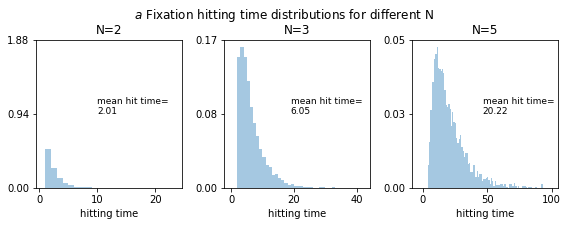

In [4]:
N=[2,3,5]
mu_a=0
mu_A=0
repeats=20000
f, axes = plt.subplots(1,len(N),figsize=(8,3))
for i in range(len(N)):
    count=0
    hit_time_dist=np.zeros(repeats)
    for j in range(repeats):
        x,hit_t=generate_trajectory(N[i],mu_a,mu_A,'ordinary',r=None)
        if hit_t>0:
            #plt.plot(range(hit_t+1),x)
            hit_time_dist[count]=hit_t
            count+=1
    data=hit_time_dist[:count]    
    bins=np.arange(data.min(), data.max() + 1)
    sns.distplot(data,bins=bins,ax=axes[i]).get_lines()[0].remove()
    axes[i].text((data.min()+data.max())/2-2,np.max(axes[i].get_ylim())/2,'mean hit time=\n%1.2f' %np.mean(data),fontsize=9)
    axes[i].set_yticks([0,np.max(axes[i].get_ylim())/2,np.max(axes[i].get_ylim())])
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[i].set_title('N=%d' %(N[i]))
    axes[i].set_xlabel('hitting time')
plt.suptitle(r'$a$ Fixation hitting time distributions for different N',y=1.03)
plt.tight_layout(w_pad=1)   

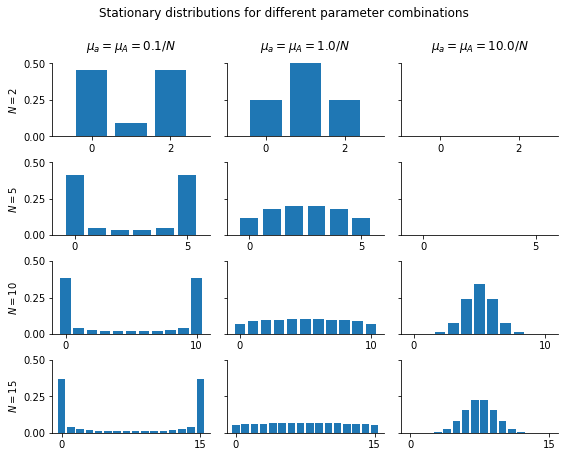

In [5]:
N=[2,5,10,15] 
L=1000
scale_parameter=[0.1,1,10.]
f, axes = plt.subplots(len(N),len(scale_parameter),figsize=(8,6))
for i in range(len(N)):
    pi_0=np.divide(np.ones(N[i]+1),N[i]+1).reshape(1,N[i]+1)#np.eye(1,N[i]+1,1)   #Indicates the initial state probability.
    for j in range(len(scale_parameter)):
        mu_a=mu_A=scale_parameter[j]/N[i]
        if mu_a<=1:
            pi_last=generate_last_state(N[i],L-1,pi_0,mu_a,mu_A,'ordinary',r=None) 
            pi_last_st=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'ordinary',r=None) 
            if np.sum(np.abs(pi_last-pi_last_st))<0.000001:
                #print('Given N=%d and mu_a=mu_A=%1.1f/N the stationary distribution is' %(N[i],scale_parameter[j]), pi_last)
                axes[i,j].bar(range(N[i]+1),pi_last.reshape(N[i]+1))
        if i==0: 
            axes[i,j].set_title(r'$\mu_a=\mu_A=%1.1f/N$' %(scale_parameter[j]),y=1.1)    
        if j==0:
            axes[i,j].set_ylabel(r'$N=%d$' %(N[i]))
        else:
            axes[i,j].set_yticklabels([])  
        axes[i,j].set_ylim([0,0.5])
        axes[i,j].set_yticks(np.linspace(0,0.5,3))
        axes[i,j].set_xlim([-1,N[i]+1])
        axes[i,j].set_xticks([0,N[i]])   
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')
    #print('*************************************************************')
plt.suptitle('Stationary distributions for different parameter combinations',y=1.05)
plt.tight_layout(h_pad=0.5,w_pad=1)   

# Moran process with selection

Given N=2, after 100000 steps, the probability of reaching fixation for a is 0.5000
Given N=2, after 100000 steps, the probability of reaching fixation (with selection) for a is 0.7500
*****************************************************
Given N=5, after 100000 steps, the probability of reaching fixation for a is 0.2000
Given N=5, after 100000 steps, the probability of reaching fixation (with selection) for a is 0.6694
*****************************************************
Given N=7, after 100000 steps, the probability of reaching fixation for a is 0.1429
Given N=7, after 100000 steps, the probability of reaching fixation (with selection) for a is 0.6670
*****************************************************
Given N=10, after 100000 steps, the probability of reaching fixation for a is 0.1000
Given N=10, after 100000 steps, the probability of reaching fixation (with selection) for a is 0.6667
*****************************************************


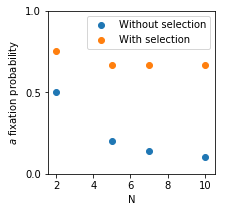

The fixation probability tends to $1-(1/r)$ as $N\to \infty$.


In [6]:
N=[2,5,7,10]
mu_a=0
mu_A=0
r=3
L=100000
f=plt.figure(figsize=(3,3))
for i in range(len(N)):
    pi_0=np.eye(1,N[i]+1,1)   #Indicates the initial state probability.
    pi_last_ordinary=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'ordinary',r) 
    pi_last_selection=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'selection',r) 
    plt.scatter([N[i]],[pi_last_ordinary[0,N[i]]],c='C0')
    plt.scatter([N[i]],[pi_last_selection[0,N[i]]],c='C1')
    plt.ylim([0,1])
    plt.yticks([0,0.5,1])
    plt.ylabel(r'$a$ fixation probability')
    plt.xlabel('N')
    plt.legend(['Without selection', 'With selection'])
    print('Given N=%d, after %d steps, the probability of reaching fixation for a is %1.4f' %(N[i],L,pi_last_ordinary[0,N[i]]))
    print('Given N=%d, after %d steps, the probability of reaching fixation (with selection) for a is %1.4f' %(N[i],L,pi_last_selection[0,N[i]]))
    print('*****************************************************')
plt.show()
print(r'The fixation probability tends to $1-(1/r)$ as $N\to \infty$.')

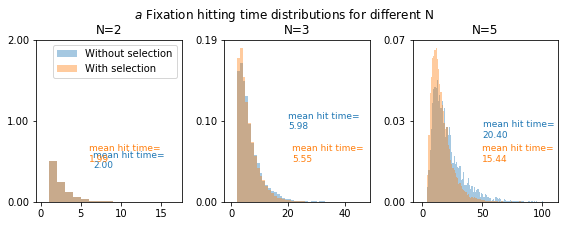

In [7]:
N=[2,3,5]
mu_a=0
mu_A=0
r=3
repeats=20000
f, axes = plt.subplots(1,len(N),figsize=(8,3))
for i in range(len(N)):
    count=0
    hit_time_dist=np.zeros(repeats)
    for j in range(repeats):
        x,hit_t=generate_trajectory(N[i],mu_a,mu_A,'ordinary',r=None)
        if hit_t>0:
            #plt.plot(range(hit_t+1),x)
            hit_time_dist[count]=hit_t
            count+=1
    data=hit_time_dist[:count]    
    bins=np.arange(data.min(), data.max() + 1)
    sns.distplot(data,bins=bins,ax=axes[i],kde_kws = {'alpha':0.5}).get_lines()[0].remove()
    axes[i].text((data.min()+data.max())/2-2,np.max(axes[i].get_ylim())/2,'mean hit time=\n%1.2f' %np.mean(data),fontsize=9,color='C0')
    count=0
    for j in range(repeats):
        x,hit_t=generate_trajectory(N[i],mu_a,mu_A,'selection',r)
        if hit_t>0:
            #plt.plot(range(hit_t+1),x)
            hit_time_dist[count]=hit_t
            count+=1
    data=hit_time_dist[:count]    
    bins=np.arange(data.min(), data.max() + 1)
    sns.distplot(data,bins=bins,ax=axes[i],kde_kws = {'alpha':0.5}).get_lines()[0].remove()
    axes[i].text((data.min()+data.max())/2-2,np.max(axes[i].get_ylim())/4,'mean hit time=\n%1.2f' %np.mean(data),fontsize=9,color='C1')
    axes[i].set_yticks([0,np.max(axes[i].get_ylim())/2,np.max(axes[i].get_ylim())])
    axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[i].set_title('N=%d' %(N[i]))
axes[0].legend(['Without selection', 'With selection'])
plt.suptitle(r'$a$ Fixation hitting time distributions for different N',y=1.03)
plt.tight_layout(w_pad=1) 

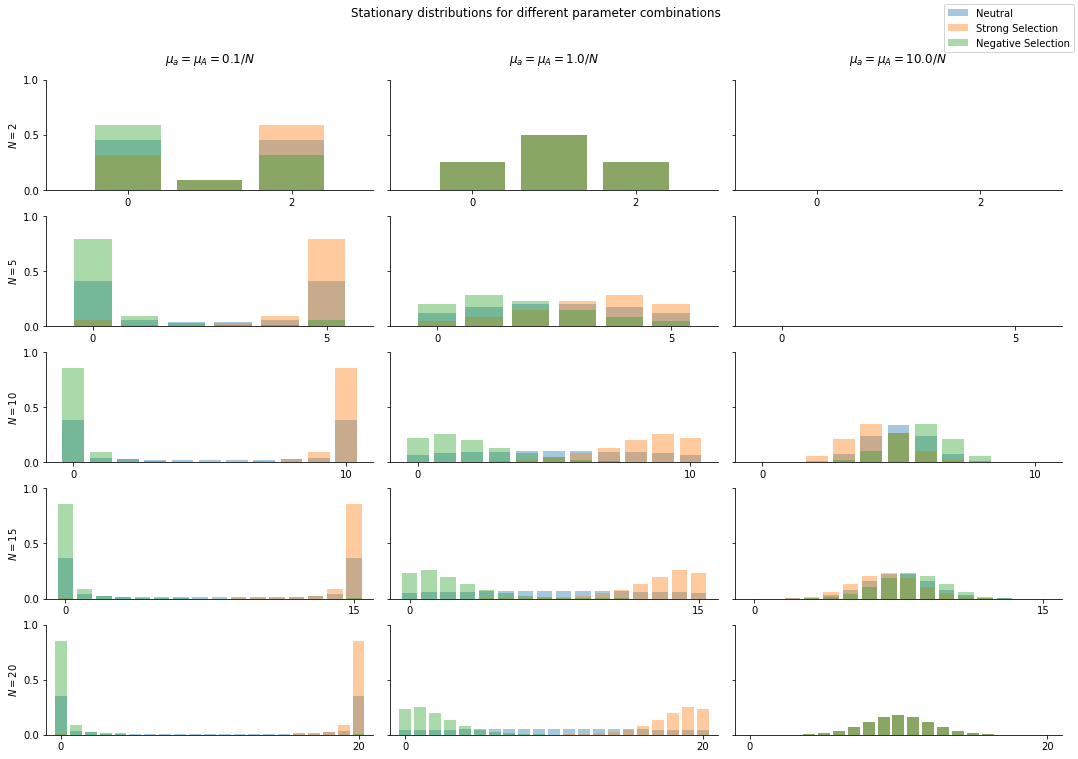

In [8]:
N=[2,5,10,15,20] 
L=1000
r=[2,0.5] #selection coefficient
scale_parameter=[0.1,1,10.]
f, axes = plt.subplots(len(N),len(scale_parameter),figsize=(15,10))
for i in range(len(N)):
    pi_0=np.divide(np.ones(N[i]+1),N[i]+1).reshape(1,N[i]+1)#np.eye(1,N[i]+1,1)   #Indicates the initial state probability.
    for j in range(len(scale_parameter)):
        mu_a=mu_A=scale_parameter[j]/N[i]
        if mu_a<=1:
            pi_last=generate_last_state(N[i],L-1,pi_0,mu_a,mu_A,'ordinary',r=None) 
            pi_last_st=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'ordinary',r=None) 
            if np.sum(np.abs(pi_last-pi_last_st))<0.0001:
                #print('Given N=%d and mu_a=mu_A=%1.1f/N the stationary distribution is' %(N[i],scale_parameter[j]), pi_last)
                axes[i,j].bar(range(N[i]+1),pi_last.reshape(N[i]+1),color='C0',alpha=0.4)
            pi_last=generate_last_state(N[i],L-1,pi_0,mu_a,mu_A,'selection',r[0]) 
            pi_last_st=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'selection',r[0]) 
            if np.sum(np.abs(pi_last-pi_last_st))<0.0001:
                #print('Given N=%d and mu_a=mu_A=%1.1f/N the stationary distribution is' %(N[i],scale_parameter[j]), pi_last)
                axes[i,j].bar(range(N[i]+1),pi_last.reshape(N[i]+1),color='C1',alpha=0.4)
            pi_last=generate_last_state(N[i],L-1,pi_0,mu_a,mu_A,'selection',r[1]) 
            pi_last_st=generate_last_state(N[i],L,pi_0,mu_a,mu_A,'selection',r[1]) 
            if np.sum(np.abs(pi_last-pi_last_st))<0.0001:
                #print('Given N=%d and mu_a=mu_A=%1.1f/N the stationary distribution is' %(N[i],scale_parameter[j]), pi_last)
                axes[i,j].bar(range(N[i]+1),pi_last.reshape(N[i]+1),color='C2',alpha=0.4)
        if i==0: 
            axes[i,j].set_title(r'$\mu_a=\mu_A=%1.1f/N$' %(scale_parameter[j]),y=1.1)    
        if j==0:
            axes[i,j].set_ylabel(r'$N=%d$' %(N[i]))
        else:
            axes[i,j].set_yticklabels([])  
        axes[i,j].set_ylim([0,0.5])
        axes[i,j].set_yticks(np.linspace(0,1,3))
        axes[i,j].set_xlim([-1,N[i]+1])
        axes[i,j].set_xticks([0,N[i]])   
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')

    #print('*************************************************************')
f.legend(['Neutral','Strong Selection','Negative Selection'])
plt.suptitle('Stationary distributions for different parameter combinations',y=1.05)
plt.tight_layout(h_pad=0.5,w_pad=1)  